In [1]:
from astropy.io import fits
import numpy as np
from typing import Tuple
import math

In [10]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import *
import matplotlib
#import plplot
from scipy import stats#from io import StringIO
print(pd.__version__)
#AttributeError: 'Series' object has no attribute 'to_numpy'
import re

import math
import astropy as astro
import scipy.ndimage as spimage
from astropy.io import fits, ascii
from astropy.table import Table, join, vstack
from astropy.cosmology import WMAP9 as cosmo
import matplotlib as mpl
#from numpy import std as biweight_midvariance
import matplotlib.cm as cm

from scipy import optimize
import scipy.stats as stats
from scipy.stats import gaussian_kde
from matplotlib import colors
import scipy.ndimage as ndimage
from collections import Counter
from matplotlib.legend import Legend
import matplotlib.patches as patches
from matplotlib import pyplot
#
#
#
import extinction


#
# seaborn
# import pandas.util.testing as tm
import seaborn as sns

#
# Jorge
#

from sel2dhist_xy import sel2dhist_xy


#
# 3D plots!
#
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#biweight_midvariance


import warnings
warnings.simplefilter("ignore")

#
# my_utils
#
from my_utils import *

#
#
#
from ndtest import *
from sklearn.decomposition import PCA

#
#
#
from scipy.optimize import leastsq, fmin
import matplotlib.animation as animation

#
# Carlos Color map
#
from cmaps_CLC import vel_map



2.2.0
2.2.0


In [11]:
def create_circular_mask(h: int, w: int, center: Tuple[int, int], radius: int) -> np.ndarray:
    """Create a boolean mask for a circle centered at `center` with given `radius`."""
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
    return dist_from_center <= radius

def extract_values_from_cube(fits_path: str, x: int, y: int, radius: int) -> np.ndarray:
    """Extract average values (or quadratic average for errors) from FITS datacube slice-by-slice."""
    
    with fits.open(fits_path) as hdul:
        data = hdul[0].data  # shape: (z, y, x)
        header = hdul[0].header
    desc_entries = extract_desc_entries(header)
    
    if data.ndim != 3:
        raise ValueError("Input FITS file must contain a 3D datacube.")

    nz, ny, nx = data.shape

    if not (0 <= x < nx and 0 <= y < ny):
        x = int(nx/2.0)
        y = int(ny/2.0)
#        raise ValueError("Provided (x, y) coordinates are outside the image bounds.")

#    print(x,y)
    mask = create_circular_mask(ny, nx, center=(x, y), radius=radius)

    result = []

    for z in range(nz):
        desc_key = f'DESC{z}'
        desc = header.get(desc_key, '')

        slice_data = data[z, :, :]
        values = slice_data[mask]

        if values.size == 0:
            result.append(np.nan)
            continue

        if desc.startswith('e_'):
            quadratic_mean = math.sqrt(np.mean(values ** 2))
            result.append(quadratic_mean)
        else:
            simple_mean = np.mean(values)
            result.append(simple_mean)

    return np.array(result),desc_entries

def extract_desc_entries(header):
    """Extract DESC# entries from FITS header as an array sorted by slice index."""
    desc_entries = []
    z_indices = []

    for key in header.keys():
        if key.startswith('DESC') and key[4:].isdigit():
            z_indices.append(int(key[4:]))

    z_indices.sort()

    for z in z_indices:
        desc_key = f'DESC{z}'
        desc_entries.append(header.get(desc_key, ''))

    return desc_entries


In [24]:
import pyphot
import os

In [ ]:
# Ensure pyphot is installed
# %pip install pyphot

# Import FilterLibrary from pyphot
#from pyphot import FilterLibrary
from astropy.wcs import WCS
from pyphot import unit
import pyphot

def extract_photometry_with_errors(fits_path: str):
    """Extract photometry (flux) in u, g, r, i-bands with errors using Monte Carlo propagation."""
    with fits.open(fits_path) as hdul:
        flux_cube = hdul[0].data  # Flux datacube
        error_cube = hdul[1].data  # Error datacube
        header = hdul[0].header

    if flux_cube.ndim != 3 or error_cube.ndim != 3:
        raise ValueError("Input FITS file must contain 3D flux and error datacubes.")

    nz, ny, nx = flux_cube.shape

    # Extract wavelength solution from WCS
    #wcs = WCS(header)
    wavelengths = header['CRVAL3']+ header['CDELT3']*np.arange(nz)

    # Load filter library
    #lib = FilterLibrary()
    wavelengths  = wavelengths * unit['AA']
    print(wavelengths)
    #flux = flux * unit['erg/s/cm**2/AA']
    lib = pyphot.get_library()
    filters = {band: lib[band] for band in ['SDSS_u', 'SDSS_g', 'SDSS_r', 'SDSS_i']}

    photometry = {}
    errors = {}

    for band, filt in filters.items():
        band_fluxes = []
        for _ in range(100):  # Monte Carlo iterations
            perturbed_flux = flux_cube + np.random.normal(0, error_cube)
            for j in range(ny):
                for i in range(nx):
                    print(i,j)
                    spectrum = perturbed_flux[:,j,i]
                    band_flux = filt.get_flux(wavelengths, spectrum * 10e-16 * unit['erg/s/cm**2/AA'])
                    band_fluxes.append(band_flux)
        photometry[band] = np.mean(band_fluxes)
        errors[band] = np.std(band_fluxes)
    return photometry, errors

In [61]:
def read_filt(filt_path: str):
    """Read filter data from a file."""
    with open(filt_path, 'r') as f:
        lines = f.readlines()
    wavelengths = []
    transmissions = []
    for line in lines:
        if not line.startswith('#'):
            parts = line.split()
            if len(parts) == 2:
                wavelengths.append(float(parts[0]))
                transmissions.append(float(parts[1]))
            elif len(parts) == 3:
                wavelengths.append(float(parts[1]))
                transmissions.append(float(parts[2]))
    return np.array(wavelengths), np.array(transmissions)

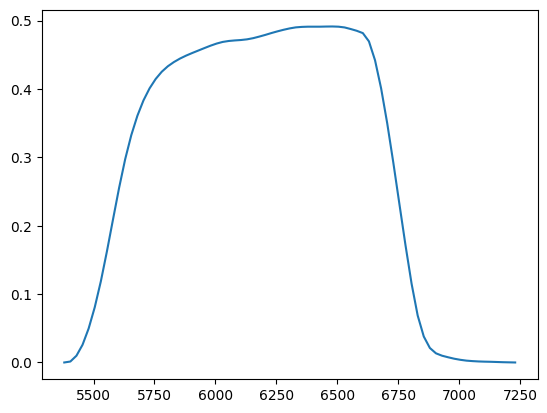

In [64]:
w_r, t_r = read_filt('filters/r.dat')
plt.plot(w_r, t_r, label='r-band filter')

In [299]:
def extract_photometry_with_errors(fits_path: str, filters: list, n_mc = 10, plot = 0):
    """Extract photometry (flux) in u, g, r, i-bands with errors using Monte Carlo propagation."""
    with fits.open(fits_path) as hdul:
        flux_cube = hdul[0].data  # Flux datacube
        error_cube = np.abs(hdul[1].data)  # Error datacube
        header = hdul[0].header

    if flux_cube.ndim != 3 or error_cube.ndim != 3:
        raise ValueError("Input FITS file must contain 3D flux and error datacubes.")

    nz, ny, nx = flux_cube.shape

    # Extract wavelength solution from WCS
    #wcs = WCS(header)
    wavelengths = header['CRVAL3']+ header['CDELT3']*np.arange(nz)
    out_cube = np.zeros((2*len(filters), ny, nx))
    out_hdu = fits.PrimaryHDU(data=out_cube)
    W_f = []
    spec_int = np.nansum(flux_cube,axis=(1,2))        
    e_spec_int = np.nanmean(error_cube,axis=(1,2))
    mask_cube = (np.nanmean(flux_cube,axis=0)==0)

    for i,filts in enumerate(filters):
        i2 = i+len(filters)
        dir = filts['dir']
        name = filts['name']
        file = filts['file']
        out_hdu.header[f'DESC_{i}'] = name
        out_hdu.header[f'DESC_{i2}'] = f'e_{name}'
        w_r, t_r = read_filt(f'{dir}/{file}')
        mask_w_r = (w_r >= wavelengths[0]) & (w_r <= wavelengths[-1])
        t_int = np.interp(wavelengths,w_r,t_r)
        t_int[spec_int<=0] = 0
        t_int[~np.isfinite(spec_int)] = 0
        images = np.zeros((n_mc,ny,nx))        
        for j in range(n_mc):  # Monte Carlo iterations
            perturbed_flux = flux_cube + 0.5*np.random.normal(0, error_cube)
            t_perturbed_flux = (perturbed_flux.T * t_int).T 
            img = np.nanmean(t_perturbed_flux[t_int>0],axis=0)/np.nanmean(t_int[t_int>0])
            img[mask_cube] = 0
            images[j,:,:] = img
        print(f'filter {name} done')
        out_cube[i,:,:] = np.nanmean(images,axis=0)
        out_cube[i2,:,:] = np.nanstd(images,axis=0)
        W_f_now = np.nanmean(w_r*t_r)/np.nanmean(t_r)
        out_hdu.header[f'wave_{i}'] = W_f_now 
        W_f.append(W_f_now)
    W_f = np.array(W_f)
    print('# calculations done!')
    if (plot==1):
        fig, ax = plt.subplots(figsize=(8,3))
        ax.fill_between(wavelengths,spec_int-e_spec_int,spec_int+e_spec_int,color='grey',alpha=0.5)
        ax.plot(wavelengths,spec_int,color='k',linewidth=2)
        max_f = []
        min_f = []
        for i,filts in enumerate(filters):
            dir = filts['dir']
            name = filts['name']
            file = filts['file']
            w_r, t_r = read_filt(f'{dir}/{file}')

            i2 = i+len(filters)
            f = np.nansum(out_cube[i,:,:])
            ef = np.nansum(out_cube[i2,:,:])
            #ax.scatter([W_f[i]],[f],m='s',color='red')
            ax.errorbar([W_f[i]],[f], [ef+0.1*f], marker='s', color='red', mfc='red', mec='black', ms=5, mew=1)
            ax.plot(w_r,t_r*f,alpha=0.7)
            max_f.append(f+ef)            
        max_f = np.array(max_f)
        ax.set_ylim(0,1.5*np.max(max_f))
        ax.set_xlabel(r'wavelength $\AA$')
        ax.set_ylabel(r'flux 10$^{-16}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$')
        fig.tight_layout()
        plt.show()
    out_hdu.data = out_cube

    if (plot==1):      
        return out_hdu,fig
    else:
        return out_hdu

In [300]:
#lib = pyphot.get_library()
#print(lib['SDSS_r'])
#filters = {band: lib[band] for band in ['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i']}


In [301]:
hdu = fits.open('tables/KG_Pipe3D_table_COSMO.fits')
tab_KG = Table(hdu[1].data)
tab_KG.rename_column('name','org_name')
tab_KG.rename_column('cubename','name')

In [302]:
#tab_KG

filter u done
filter g done
filter r done
filter i done
filter z done
# calculations done!


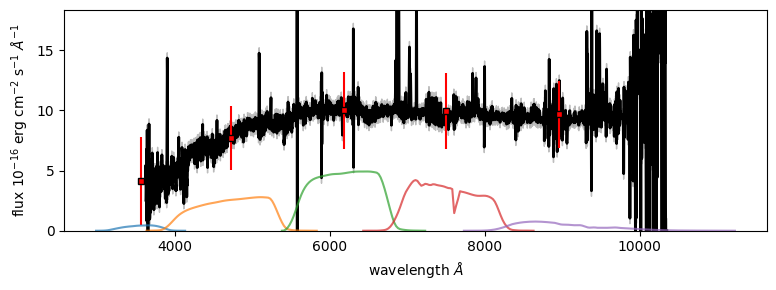

Photometry for KG-MaNGA-1-207 done
filter u done
filter g done
filter r done
filter i done
filter z done
# calculations done!


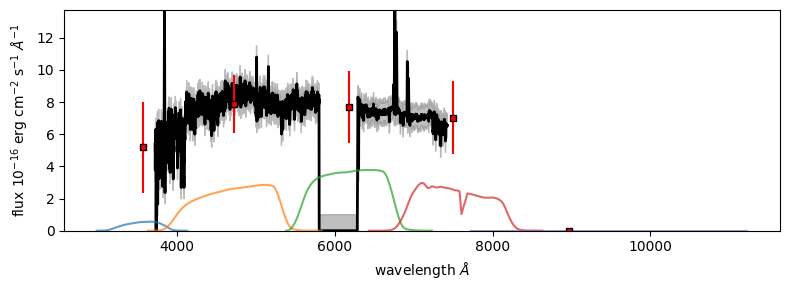

Photometry for KG-SAMI-107214 done


In [303]:
HP_dir = 'cubes'
out_dir = 'images'
x_pixel = -1
y_pixel = -1
radius = 2.5
I = 0

filters = []

filt = {'dir': 'filters' , 'name': 'u', 'file': 'u.dat'}
filters.append(filt)
filt = {'dir': 'filters' , 'name': 'g', 'file': 'g.dat'}
filters.append(filt)
filt = {'dir': 'filters' , 'name': 'r', 'file': 'r.dat'}
filters.append(filt)
filt = {'dir': 'filters' , 'name': 'i', 'file': 'i.dat'}
filters.append(filt)
filt = {'dir': 'filters' , 'name': 'z', 'file': 'z.dat'}
filters.append(filt)


for tab_pe_now in tab_KG:
    kgas_id = tab_pe_now['KGAS_ID']
    cubename = tab_pe_now['name']
    fits_file = f'{HP_dir}/{cubename}.cube.fits.gz'
    out_file = f'{out_dir}/{cubename}.phot.cube.fits.gz'
#    print(f'{fits_file}')
#    try:
    if(os.path.isfile(fits_file)):
        hdu_now,fig = extract_photometry_with_errors(fits_file, filters, n_mc = 5, plot =1)
        hdu_now.writeto(out_file,overwrite=True)
        out_ps = out_file.replace('.fits.gz','.pdf')
        out_ps = out_ps.replace('.fits','.pdf')
        fig.savefig(out_ps)
        print(f'Photometry for {cubename} done')
#    except:
#        print('.',end='')
#        print(f'file {fits_file} not found')
    